In [14]:
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor
import numpy as np

# Function to create SQLite database and table
def create_database_table():
    conn = sqlite3.connect('movie_data.db')
    cursor = conn.cursor()
    cursor.execute('''CREATE TABLE IF NOT EXISTS movies (
                        director_name TEXT,
                        num_critic_for_reviews REAL,
                        director_facebook_likes REAL,
                        actor_3_facebook_likes REAL,
                        actor_2_name TEXT,
                        actor_1_facebook_likes REAL,
                        genres TEXT,
                        actor_1_name TEXT,
                        movie_title TEXT,
                        num_voted_users INTEGER,
                        cast_total_facebook_likes INTEGER,
                        actor_3_name TEXT,
                        facenumber_in_poster REAL,
                        movie_imdb_link TEXT,
                        num_user_for_reviews REAL,
                        title_year REAL,
                        actor_2_facebook_likes REAL,
                        imdb_score REAL,
                        movie_facebook_likes INTEGER
                    )''')
    conn.commit()
    conn.close()

# Function to fetch data from SQLite database
def fetch_data():
    conn = sqlite3.connect('movie_data.db')
    data = pd.read_sql_query("SELECT * FROM movies", conn)
    conn.close()
    return data

# Data Cleaning and Preprocessing function
def clean_preprocess_data(data):
    data.fillna(0, inplace=True)
    numerical_features = ['num_critic_for_reviews', 'director_facebook_likes', 'actor_3_facebook_likes',
                          'actor_1_facebook_likes', 'num_voted_users', 'cast_total_facebook_likes',
                          'facenumber_in_poster', 'num_user_for_reviews', 'title_year', 'actor_2_facebook_likes',
                          'movie_facebook_likes']
    scaler = StandardScaler()
    data[numerical_features] = scaler.fit_transform(data[numerical_features])
    data['genres'] = data['genres'].apply(lambda x: x.split('|')[0])
    label_encoder = LabelEncoder()
    data['genres'] = label_encoder.fit_transform(data['genres'])
    return data

# Fetch data from CSV file
data = pd.read_csv('/Users/xueyilu/Desktop/Project-4/cleaned_data.csv')

# Create database and table if not exists
create_database_table()

# Insert data into the SQLite table 'movies'
data.to_sql('movies', 'sqlite:///movie_data.db', if_exists='replace', index=False)

# Fetch data from SQLite database
data = fetch_data()

# Data Cleaning and Preprocessing
data = clean_preprocess_data(data)


# create_database_table()
# data = fetch_data()
# data = clean_preprocess_data(data)

X = data.drop(['movie_title', 'movie_imdb_link', 'director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name', 'imdb_score'], axis=1)
y = data['imdb_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define base models
random_forest = RandomForestRegressor(random_state=42)
gradient_boosting = GradientBoostingRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)

# Hyperparameter tuning
param_grid_rf = {'n_estimators': [100, 500], 'max_depth': [10, 20], 'min_samples_split': [2, 5]}
param_grid_gb = {'n_estimators': [100, 300], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]}
param_grid_xgb = {'n_estimators': [100, 300], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]}

grid_search_rf = GridSearchCV(random_forest, param_grid_rf, cv=5, scoring='r2')
grid_search_gb = GridSearchCV(gradient_boosting, param_grid_gb, cv=5, scoring='r2')
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='r2')

best_rf = grid_search_rf.fit(X_train, y_train).best_estimator_
best_gb = grid_search_gb.fit(X_train, y_train).best_estimator_
best_xgb = grid_search_xgb.fit(X_train, y_train).best_estimator_

# Stacking regressor
stacking_regressor = StackingRegressor(
    estimators=[('rf', best_rf), ('gb', best_gb), ('xgb', best_xgb)],
    final_estimator=Ridge()
)
stacking_regressor.fit(X_train, y_train)
y_pred_stacking = stacking_regressor.predict(X_test)
r2_stacking = r2_score(y_test, y_pred_stacking)
mse_stacking = mean_squared_error(y_test, y_pred_stacking)

print(f"Stacking Regressor - R-squared: {r2_stacking:.4f}, Mean Squared Error: {mse_stacking:.4f}")
joblib.dump(stacking_regressor, 'best_model.pkl')
print("Best model saved successfully.")


Stacking Regressor - R-squared: 0.5081, Mean Squared Error: 0.6369
Best model saved successfully.


In [11]:
def regression_accuracy(y_true, y_pred, tolerance=0.1):
    """
    Calculate the percentage of predictions within a certain tolerance of the actual values.
    
    :param y_true: array-like, true target values
    :param y_pred: array-like, predicted values
    :param tolerance: float, the percentage tolerance for considering predictions as accurate
    :return: float, the accuracy of predictions within the specified tolerance
    """
    tolerance_limit = tolerance * np.abs(y_true)
    return np.mean(np.abs(y_true - y_pred) <= tolerance_limit)

accuracy = regression_accuracy(y_test, y_pred_stacking, tolerance=0.1)  
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.6748


In [15]:
y_pred_train = model.predict(X_train)

In [16]:
accuracy_train = regression_accuracy(y_train, y_pred_train, tolerance=0.1)  

In [18]:
print("Accuracy_train", accuracy_train)

Accuracy_train 0.8620396600566572


      Actual IMDB Score  Predicted IMDB Score     Error
4943                7.2              5.936544  1.263456
1919                7.0              6.709759  0.290241
1049                6.4              6.682310 -0.282310
4697                6.5              5.932678  0.567322
3312                6.1              5.339052  0.760948


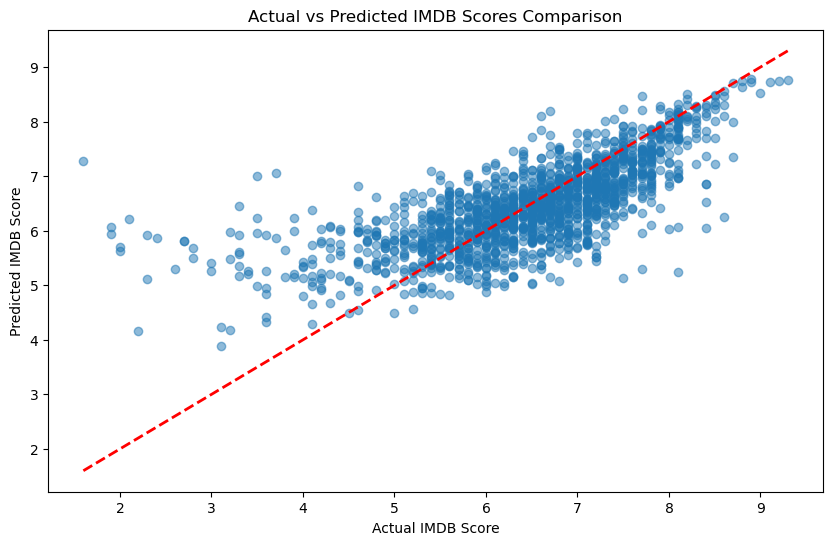

In [12]:
# Load the trained model
model = joblib.load('best_model.pkl')

# Make predictions
y_pred = model.predict(X_test)

# Create a DataFrame to compare predictions with actual values
results_df = pd.DataFrame({'Actual IMDB Score': y_test, 'Predicted IMDB Score': y_pred})

# Calculate the error in predictions
results_df['Error'] = results_df['Actual IMDB Score'] - results_df['Predicted IMDB Score']

# Display the first few rows of the results
print(results_df.head())

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Diagonal line for reference
plt.xlabel('Actual IMDB Score')
plt.ylabel('Predicted IMDB Score')
plt.title('Actual vs Predicted IMDB Scores Comparison')
plt.show()

# Save the results to a CSV file for further analysis
results_df.to_csv('model_predictions.csv', index=False)
